In [2]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [3]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import math

In [4]:
from fpl import FPL
import aiohttp
import asyncio

### The fpl module is a nice python wrapper for the Fantasy Premier League API, it makes getting fpl data pretty straightforward!

In [5]:
session = aiohttp.ClientSession()
fpl = FPL(session)

#### Get the league ID from url in league standings page on FPL

In [6]:
league_id=796303  #796303 #774804

In [7]:
classic_league = await fpl.get_classic_league(league_id=league_id) 
standings = await classic_league.get_standings(page=1) # if its a big league (50+ players), may require iterating through pages

In [8]:
print(classic_league)

El Diablo - 796303


In [9]:
standings

{'has_next': False,
 'number': 1,
 'results': [{'id': 21203577,
   'entry_name': 'Sheffield Thursday',
   'event_total': 40,
   'player_name': 'Jordan Calcutt',
   'movement': 'up',
   'own_entry': False,
   'rank': 1,
   'last_rank': 2,
   'rank_sort': 1,
   'total': 1733,
   'entry': 1651753,
   'league': 796303,
   'start_event': 1,
   'stop_event': 38},
  {'id': 19960176,
   'entry_name': 'Flat Stanley FC',
   'event_total': 11,
   'player_name': 'Patrick Wray',
   'movement': 'down',
   'own_entry': False,
   'rank': 2,
   'last_rank': 1,
   'rank_sort': 2,
   'total': 1722,
   'entry': 3489755,
   'league': 796303,
   'start_event': 1,
   'stop_event': 38},
  {'id': 20024403,
   'entry_name': 'Steady Eddy FC',
   'event_total': 19,
   'player_name': 'Edward Stevenson',
   'movement': 'same',
   'own_entry': False,
   'rank': 3,
   'last_rank': 3,
   'rank_sort': 3,
   'total': 1653,
   'entry': 2098219,
   'league': 796303,
   'start_event': 1,
   'stop_event': 38},
  {'id': 2072

### function to parse points and total points from each players 'get_gameweek_history'

In [10]:
def get_points(gameweek_history):
    points=[]
    total_points=[]
    for i in gameweek_history:
        #print(i['total_points'])
        points.append(i['points'])
        total_points.append(i['total_points'])
    return points, total_points

### Using the 'entry' code in the above standings dictionary, get gameweek data for each player using the 'get_gameweek_history' method

### Create a dictionary, for each player a list of their gameweek point scores and a rolling total score e.g.:

{'Player 1':{'points':[53, 58, 42, ...], 'total_points':[53, 111, 153, ...]}, 'Player 2': etc}

In [11]:
data_dict= {}
for item in standings['results']:
    name = item['player_name']
    id = item['entry']
    #get gw data for id
    user =await fpl.get_user(id)
    gameweek_history = await user.get_gameweek_history()
    points, total_points = get_points(gameweek_history) 
    data_dict[name] = {}
    data_dict[name]['points'] = points
    data_dict[name]['total_points'] = total_points

In [12]:
data_dict

{'Jordan Calcutt': {'points': [70,
   81,
   46,
   39,
   66,
   60,
   49,
   42,
   42,
   63,
   66,
   34,
   32,
   70,
   37,
   56,
   53,
   39,
   79,
   37,
   39,
   71,
   51,
   59,
   61,
   61,
   50,
   52,
   37,
   41,
   20,
   111,
   40],
  'total_points': [70,
   151,
   197,
   232,
   298,
   358,
   407,
   449,
   491,
   554,
   620,
   654,
   686,
   752,
   789,
   841,
   894,
   933,
   1012,
   1049,
   1088,
   1159,
   1210,
   1269,
   1330,
   1391,
   1441,
   1493,
   1530,
   1571,
   1587,
   1698,
   1733]},
 'Patrick Wray': {'points': [29,
   64,
   56,
   43,
   42,
   48,
   57,
   48,
   38,
   68,
   48,
   52,
   75,
   37,
   56,
   41,
   33,
   106,
   69,
   27,
   71,
   41,
   61,
   54,
   66,
   77,
   46,
   55,
   56,
   54,
   12,
   81,
   11],
  'total_points': [29,
   93,
   149,
   192,
   234,
   282,
   339,
   387,
   425,
   493,
   541,
   593,
   668,
   705,
   761,
   802,
   835,
   941,
   1010,
   1037,
   1108,

In [13]:
# just a quick check to make sure all list are the same length, remove player if they're not...
for item, lst in data_dict.items():
    print(item, len(data_dict[item]['points']), len(data_dict[item]['total_points']))

Jordan Calcutt 33 33
Patrick Wray 33 33
Edward Stevenson 33 33
Joe Poole 33 33


In [14]:
#data_dict.pop()   # manually remove a player if lists are of differeing lengths to the others

# Points Metrics

## Use the 'points' list for each player to create a points dataframe

In [15]:
points_only_dict = dict((k, data_dict[k]['points']) for k in (data_dict.keys()))

In [16]:
df_points = pd.DataFrame(points_only_dict)

In [17]:
df_points[:3]

,Jordan Calcutt,Patrick Wray,Edward Stevenson,Joe Poole
0,70,29,62,66
1,81,64,73,67
2,46,56,44,38


### Create a rolling mean for each gameweek

In [18]:
def rolling_mean(df, col):
    
    df[col + ' mean'] = df[col].expanding().mean()
    
    return df

In [19]:
num_players = len(df_points.columns)

In [20]:
for i in df_points.columns[:num_players]:
    df_points = rolling_mean(df_points, i)

In [21]:
df_points[:3]

,Jordan Calcutt,Patrick Wray,Edward Stevenson,Joe Poole,Jordan Calcutt mean,Patrick Wray mean,Edward Stevenson mean,Joe Poole mean
0,70,29,62,66,70.000000,29.000000,62.000000,66.0
1,81,64,73,67,75.500000,46.500000,67.500000,66.5
2,46,56,44,38,65.666667,49.666667,59.666667,57.0


### Quick plot just to insepct the data...

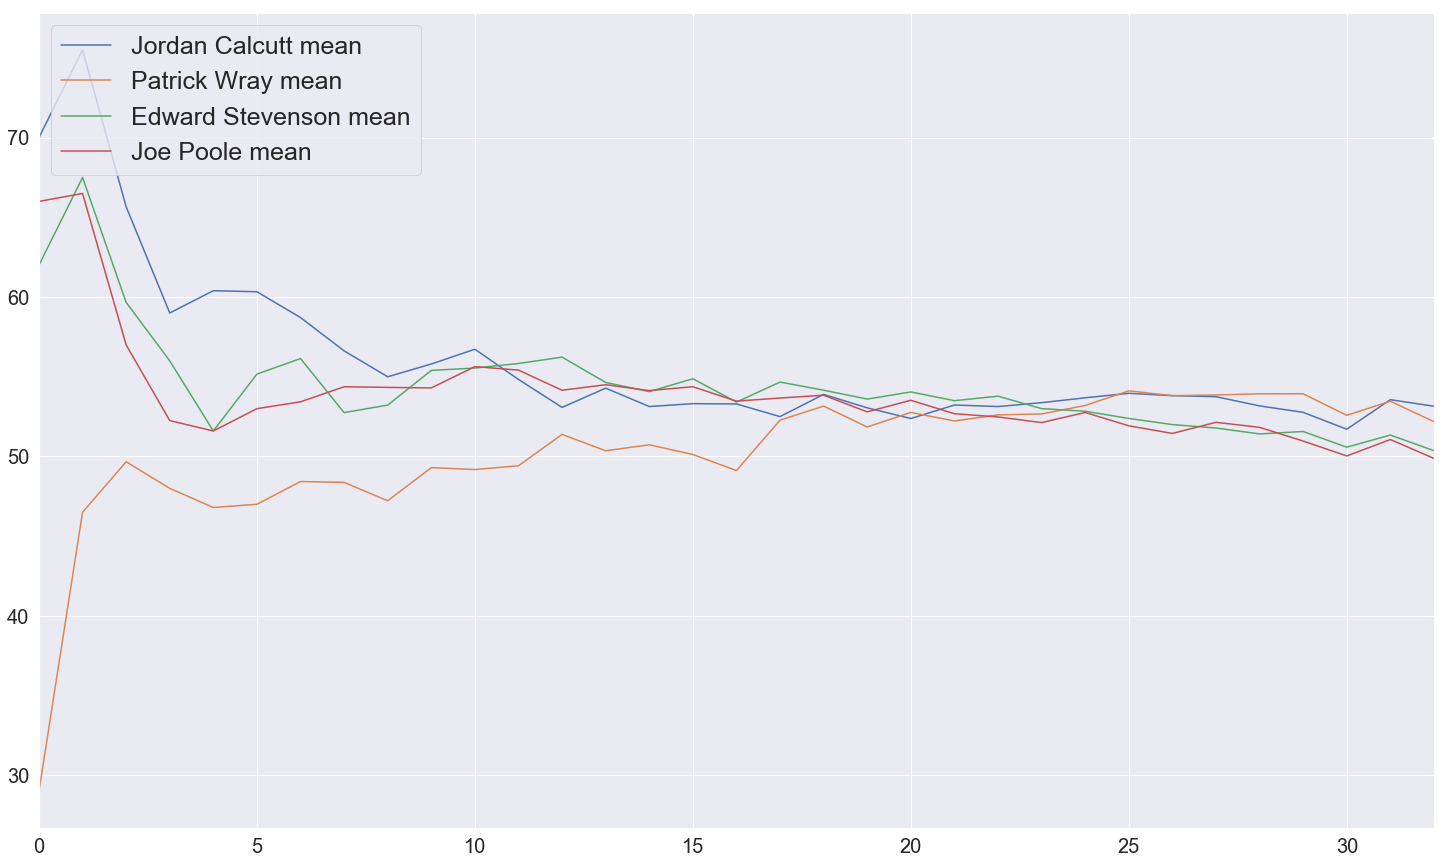

In [22]:
df_points.iloc[:,num_players:].plot(figsize=(25,15), fontsize=20).legend(loc=2, fontsize = 25)

## Total Points Metrics

use dictioanry from above to create a dataframe of total points per player, per gameweek

In [23]:
total_points_only_dict = dict((k, data_dict[k]['total_points']) for k in (data_dict.keys()))

In [24]:
df_total = pd.DataFrame(total_points_only_dict)

In [25]:
df_total[:3]

,Jordan Calcutt,Patrick Wray,Edward Stevenson,Joe Poole
0,70,29,62,66
1,151,93,135,133
2,197,149,179,171


In [26]:
df_total = pd.DataFrame(df_total.T.unstack())

In [27]:
df_total.reset_index(inplace=True)

In [28]:
df_total.columns = ['gameweek', 'player', 'total_points']

In [29]:
df_total[:3]

,gameweek,player,total_points
0,0,Jordan Calcutt,70
1,0,Patrick Wray,29
2,0,Edward Stevenson,62


### Calculate the rank of each player, for each gameweek:

In [30]:
df_total['gameweek_rank'] = df_total.groupby('gameweek')['total_points'].rank(ascending=False, method='first').astype(int)

In [31]:
df_total = df_total[['player', 'gameweek_rank', 'gameweek']].pivot(index='gameweek', columns='player')

In [32]:
df_total[:3]

gameweek_rank                                      
player   Edward Stevenson Joe Poole Jordan Calcutt Patrick Wray
gameweek                                                       
0                       3         2              1            4
1                       2         3              1            4
2                       2         3              1            4

### Quick plot, just to check the data looks alright...

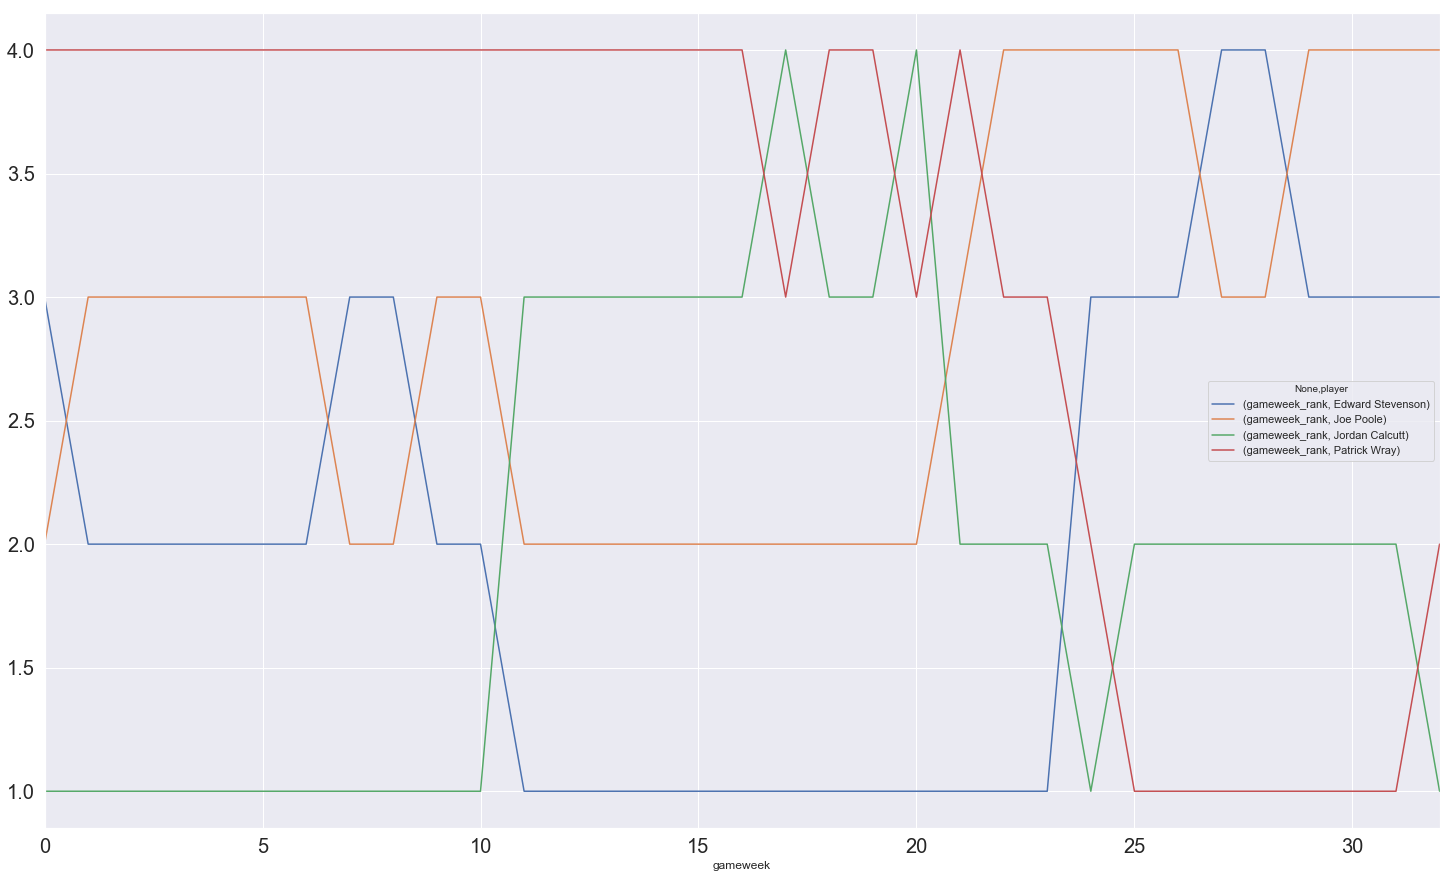

In [33]:
df_total.plot(figsize=(25,15), fontsize=20)

### This is fairly insightful, so clean up the data and plot using seaborn

In [34]:
df_total.columns

MultiIndex(levels=[['gameweek_rank'], ['Edward Stevenson', 'Joe Poole', 'Jordan Calcutt', 'Patrick Wray']],
           codes=[[0, 0, 0, 0], [0, 1, 2, 3]],
           names=[None, 'player'])

#### clean up messy multiindex...

In [35]:
df_total = df_total.T.reset_index(level=0, drop=True).reset_index().set_index('player').T  # bit messy...

In [36]:
df_total[:5]

player,Edward Stevenson,Joe Poole,Jordan Calcutt,Patrick Wray
gameweek,,,,
0,3,2,1,4
1,2,3,1,4
2,2,3,1,4
3,2,3,1,4
4,2,3,1,4


In [37]:
#gameweek starts at 1...
df_total.index = range(1,len(df_total.index)+1, 1)

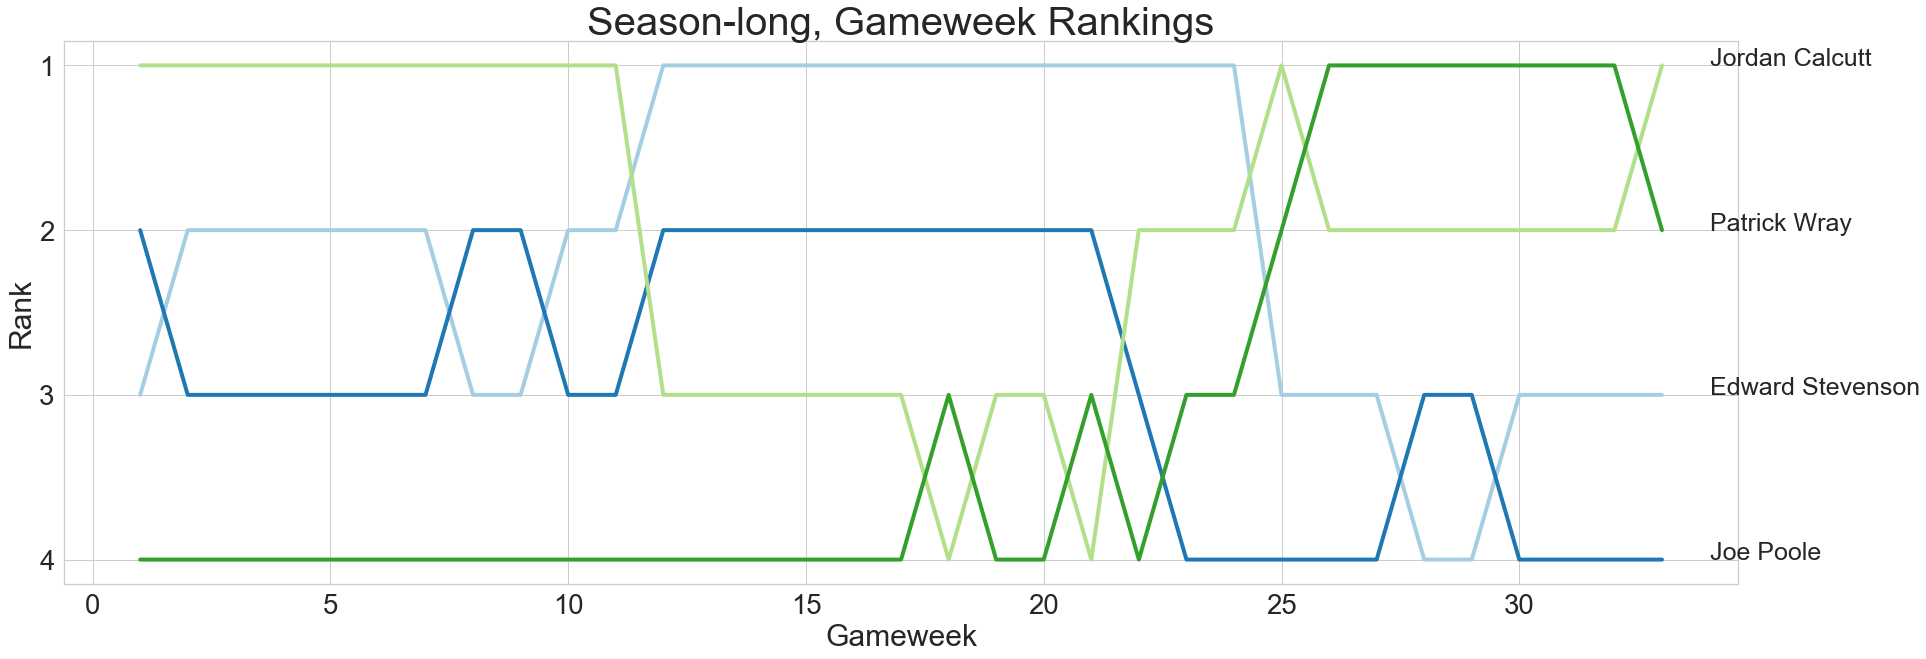

In [38]:
sns.set(rc={'figure.figsize':(30,10)}, font_scale = 2.5)
sns.set_style("whitegrid")
sns.set_palette("Paired")
ax = sns.lineplot(data=df_total, dashes=False, lw=4,legend=None )
ax.invert_yaxis()
#plt.xlim(-5,35)
plt.yticks(range(1,num_players+1,1))

plt.xlabel("Gameweek",fontsize=30)
plt.ylabel("Rank", fontsize=30)
plt.title("Season-long, Gameweek Rankings", fontsize=40)

for player in df_total.columns:
    ax.text(len(df_total)+1,df_total.tail(1)[player].values[0],player, fontsize=25)
    #ax.text(-4,df_total.head(1)[player].values[0]+0.3,player, fontsize=15)
    
fig = ax.get_figure()
#fig.savefig('league_rank.png') 

## Cumulative Points

In [39]:
dfc = pd.DataFrame(total_points_only_dict)

Text(0, 0.5, 'Total Points')

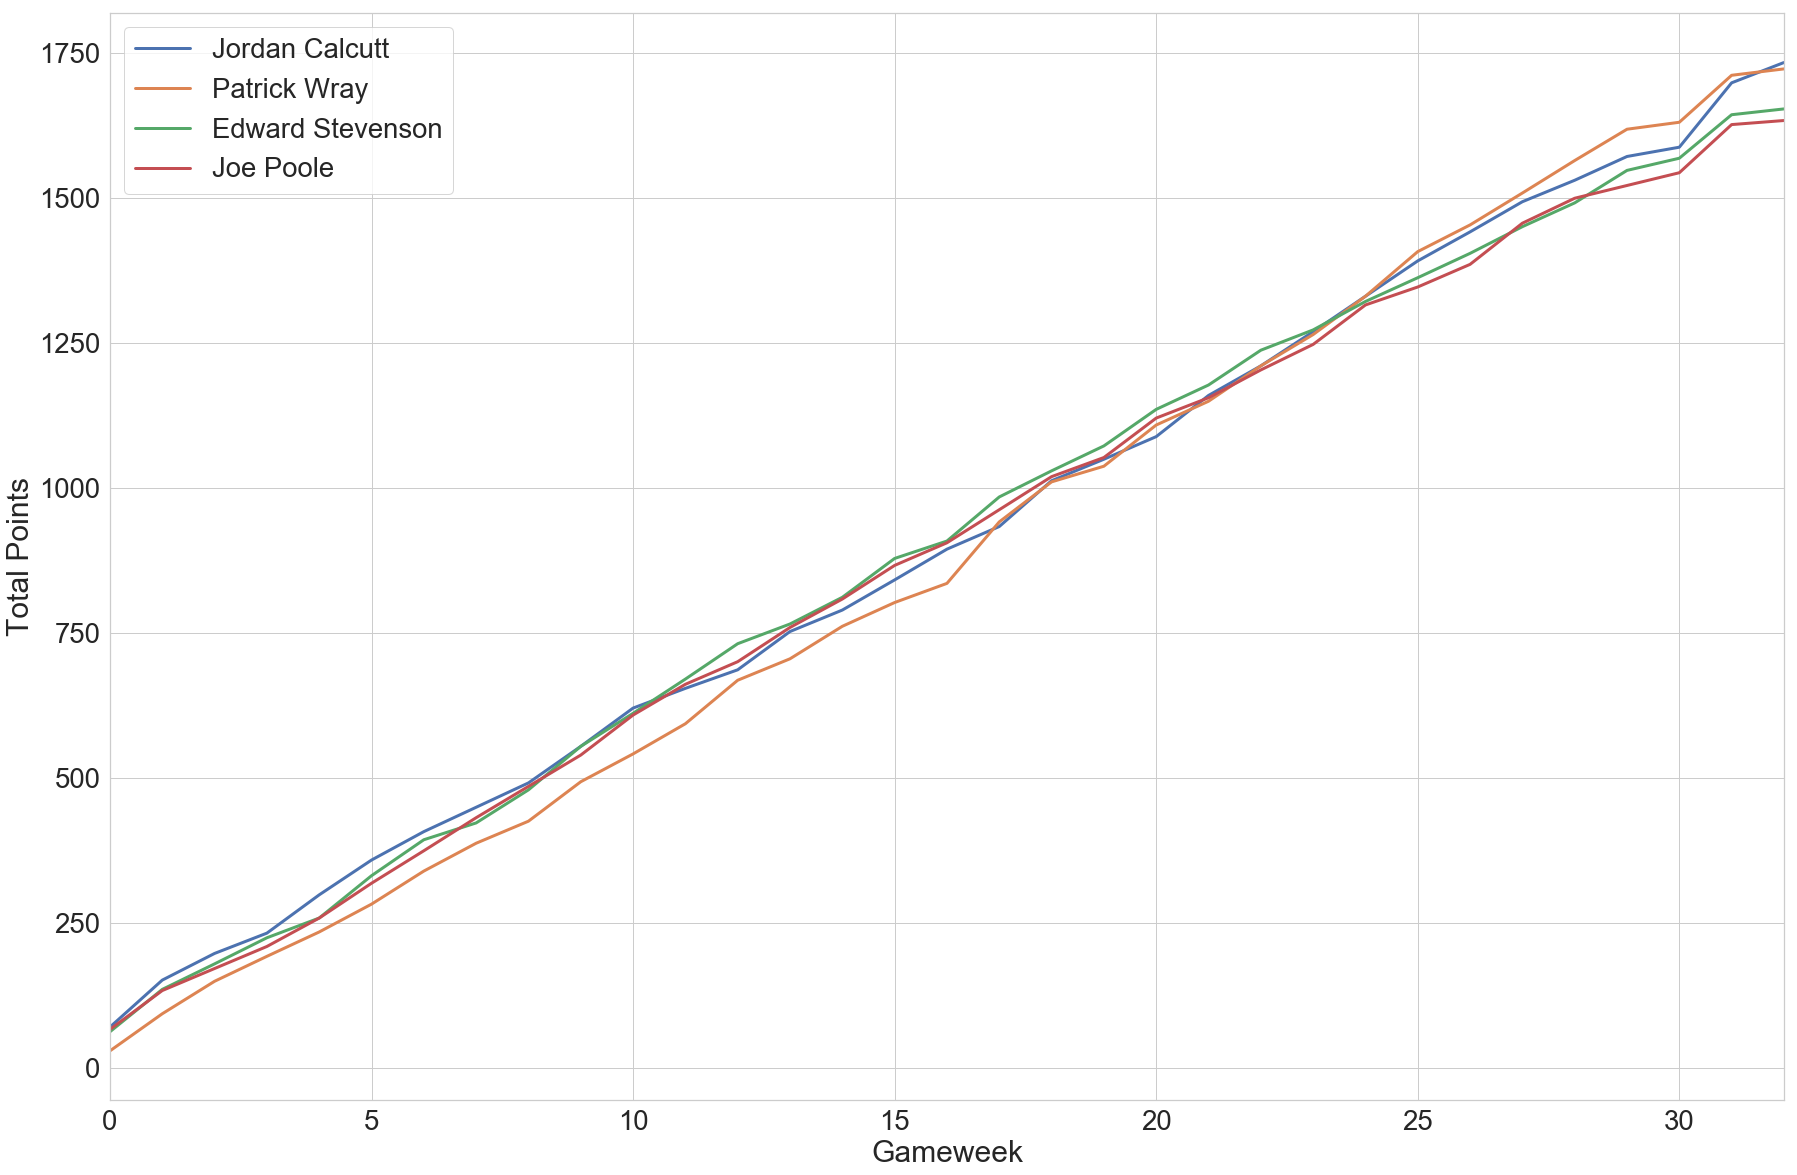

In [42]:
sns.set(rc={'figure.figsize':(30,20)}, font_scale = 2.5)
sns.set_style("whitegrid")
dfc.plot(lw=3)
plt.xlabel("Gameweek",fontsize=30)
plt.ylabel("Total Points", fontsize=30)